# Анализ закономерностей, определяющих успешность продаж игры, в срезе платформ, жанров и рейтингов. С целью построения прогнозов на следующий год.

Цель проекта выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Предварительный этап

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9017,Casper: Spirit Dimensions,PS2,2001.0,Platform,0.07,0.05,0.00,0.02,58.0,3.5,E
11483,Jikkyou Powerful Major League 2009,PS2,2009.0,Sports,0.00,0.00,0.08,0.00,NaN,NaN,NaN
6541,Drakan: The Ancients' Gates,PS2,2002.0,Adventure,0.13,0.10,0.00,0.03,78.0,9,M
1014,Crackdown,X360,2007.0,Shooter,1.00,0.53,0.03,0.18,83.0,8,M
2356,Call of Duty: Modern Warfare 2,PC,2009.0,Shooter,0.01,0.79,0.00,0.09,86.0,4.2,M


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
#data.sort_values(by='Name')[:40]

## Подготовка данных

### Коректировка назвайний стобцов

In [7]:
data.columns = data.columns.str.lower()

### Обработка пропусков

По предварительной оценке. Большая часть пропусков приходится на данные за период не имеющиюй большого значения для прогнозированияю, в свзи с устаревшими тенденциями. Восстановить оценки пользователей и критиков заскапив тот же metacritics, в учебном проекте большого смысла не имеет, оставляю как есть. 

In [8]:
data[data['year_of_release'] >= 2010].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5277 non-null   object 
 1   platform         5277 non-null   object 
 2   year_of_release  5277 non-null   float64
 3   genre            5277 non-null   object 
 4   na_sales         5277 non-null   float64
 5   eu_sales         5277 non-null   float64
 6   jp_sales         5277 non-null   float64
 7   other_sales      5277 non-null   float64
 8   critic_score     2312 non-null   float64
 9   user_score       3179 non-null   object 
 10  rating           3113 non-null   object 
dtypes: float64(6), object(5)
memory usage: 494.7+ KB


In [89]:
data[(data['year_of_release'] >= 2010) & act_data['user_score'].isna() | act_data['critic_score'].isna()].groupby('platform')['name'
].agg('count')

platform
3DS     296
DS       30
PC       53
PS3     280
PS4     143
PSP     172
PSV     305
Wii      49
WiiU     58
X360    121
XOne     82
Name: name, dtype: int64

In [91]:
data[(data['year_of_release'] >= 2010) & act_data['user_score'].isna()].groupby('platform')['name'
].agg('count')

platform
3DS     282
DS       28
PC       44
PS3     210
PS4     135
PSP     169
PSV     281
Wii      37
WiiU     47
X360     57
XOne     65
Name: name, dtype: int64

In [92]:
data[(data['year_of_release'] >= 2010) & act_data['critic_score'].isna()].groupby('platform')['name'
].agg('count')

platform
3DS     292
DS       30
PC       52
PS3     279
PS4     140
PSP     172
PSV     304
Wii      49
WiiU     57
X360    121
XOne     78
Name: name, dtype: int64

Nan в рейтинге критиков или рейтинги пользователей присутсвует во платформах. При расчетах с рейтингом буду использовать только данные без nan.

### Значение tbd в user_score

Пока что ставлю null, что бы не мешало вычислениям со столбцом. Предпологаю, что на игру было слишком мало отзывов для составления адеватнго рейтинга, по примеру с metacritic.

In [9]:
data['user_score'].replace('tbd', np.nan, inplace=True)

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'])

In [11]:
#tmp_data = data[data['year_of_release'] >= 2010]
#tmp_data = data[data['user_score'] == 'tbd']
#tmp_data['platform'].value_counts()
#tmp_data[tmp_data['platform'] == 'PC']

###  Суммарные продажи

In [12]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## EDA

### Выпуск игр по годам

In [13]:
df = data.groupby('year_of_release')['name'].count().reset_index()
df.columns = ['year', 'count']
df['year'] = df['year'].map(int)

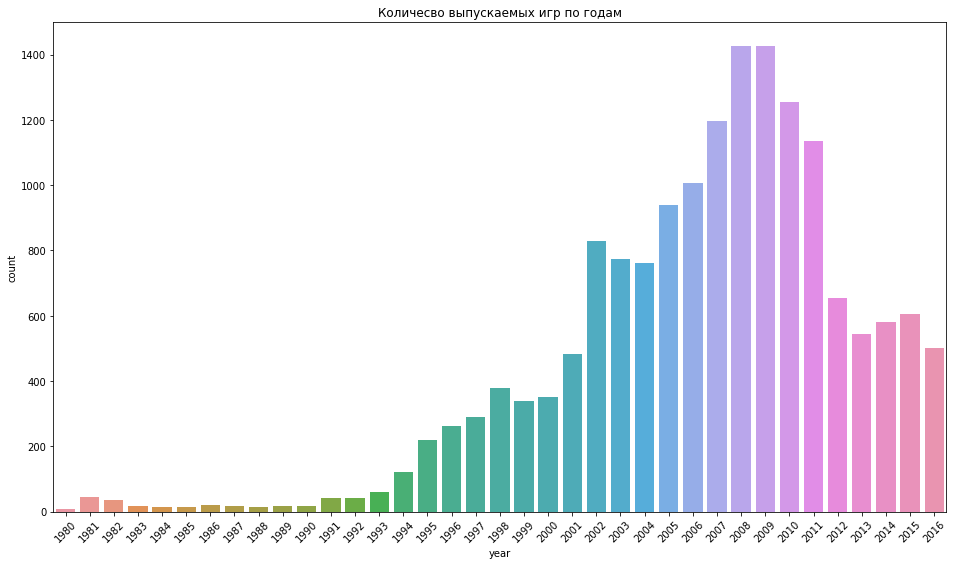

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.title('Количесво выпускаемых игр по годам')
_=sns.barplot(data=df, x='year', y='count', ax=ax)

Пик роста числа выпускаемыз игр прихрдится 2007 - 2009 годы, это может быть связанно с большим числом платформ в эти годы. Данные за этот период могут быть не актуальны для прогноза на 2017 из-за устаревания большинства этих платформ. Данные за 2012 - 2016  могут наиболее актуальными.

### Продажи по платформам и годам

Топ 10 платформ.

In [15]:
top10 = data.groupby('platform')['total_sales'].sum().reset_index().\
sort_values(by='total_sales')[-1:-10:-1]

In [16]:
df = data[data['platform'].isin(top10['platform'])].\
                                groupby(['year_of_release','platform'])['total_sales'].\
                                sum().\
                                reset_index()
df.columns = ['year','platform', 'sum']
df['year'] = df['year'].map(int)

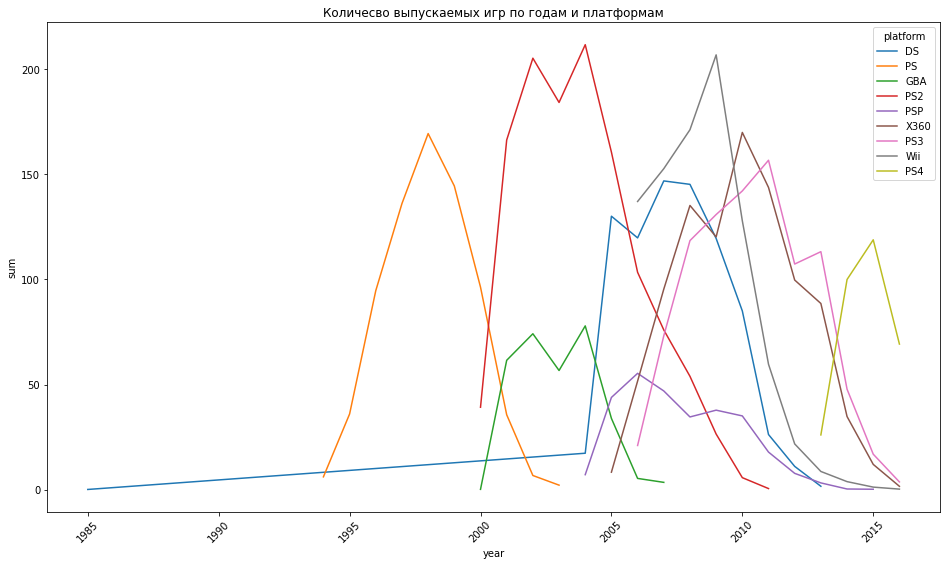

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.title('Количесво выпускаемых игр по годам и платформам')
_=sns.lineplot(data=df, x='year', y='sum',hue='platform', ax=ax)

Судя по графику, полный жизненый цикл платформы составляет 10 лет, для большинства платформ. Однако для PS4 это уже не верно, видно что жизненый цикл составит пример 6 лет, т.е процесс устаревания ускорялся в последние 10 лет. Продажи распределены нормально. Пик продаж приходится на середину, жизненого цикла платформы. Тк, мы хотим прогноз на 2017 год, не стоит рассматривать платформы, жизненый цикл которых, перешел свой пик больше определенного времени (примерно 2 года), к 2017 году. Тк выбор не большой, есть смысл ограничится данными включающими PS4. Т.е взять последние 4 года. Такой подход позволит избежать устаревших трендов. Когда на рынке главенствуют платформы адаптированые под платформеры, все делают ставки на выпуск платформеров и это будет наиболее популярный жанр. Это не значит что в 2017 все кинутся играть в платформер.

### Актуальный период

Данные конечно кукольные, PC, явно подвинули, что бы не пришлось анализировать консольный рынок отдельно, как это и следует делать. Поделить все платформы хотя бы на портативные консоли, консоли, PC. Учитываю информацию полученную на предыдущих этапах, получается 2886 тайтлов или 1671 уникальный для всех платформ тайтл.

In [18]:
act_data = data[(data['year_of_release'] >= 2012)]

In [19]:
act_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2886 non-null   object 
 1   platform         2886 non-null   object 
 2   year_of_release  2886 non-null   float64
 3   genre            2886 non-null   object 
 4   na_sales         2886 non-null   float64
 5   eu_sales         2886 non-null   float64
 6   jp_sales         2886 non-null   float64
 7   other_sales      2886 non-null   float64
 8   critic_score     1312 non-null   float64
 9   user_score       1531 non-null   float64
 10  rating           1611 non-null   object 
 11  total_sales      2886 non-null   float64
dtypes: float64(8), object(4)
memory usage: 293.1+ KB


In [20]:
act_data.nunique()

name               1671
platform             11
year_of_release       5
genre                12
na_sales            193
eu_sales            174
jp_sales             95
other_sales          88
critic_score         73
user_score           84
rating                4
total_sales         452
dtype: int64

Далее работаю только с этим срезом данных.

### Динамика продаж по платформам

Динамику буду считать как прирост продаж относительно пред. периода. Решение буду принимать по относительным и абсолютным продажам.

In [21]:
df = act_data.groupby(['year_of_release','platform'])['total_sales'].sum().reset_index()
df.columns = ['year','platform', 'sum']
df['year'] = df['year'].map(int)

Для удобства соберу продажи в сводную таблицу по платформам и годам и получу динамамику как отношение текущих продаж к продажам предыдущего периода с помощью сдвига, в данном случае на год.

In [22]:
df = pd.pivot_table(df, columns = 'year', index='platform', values='sum')

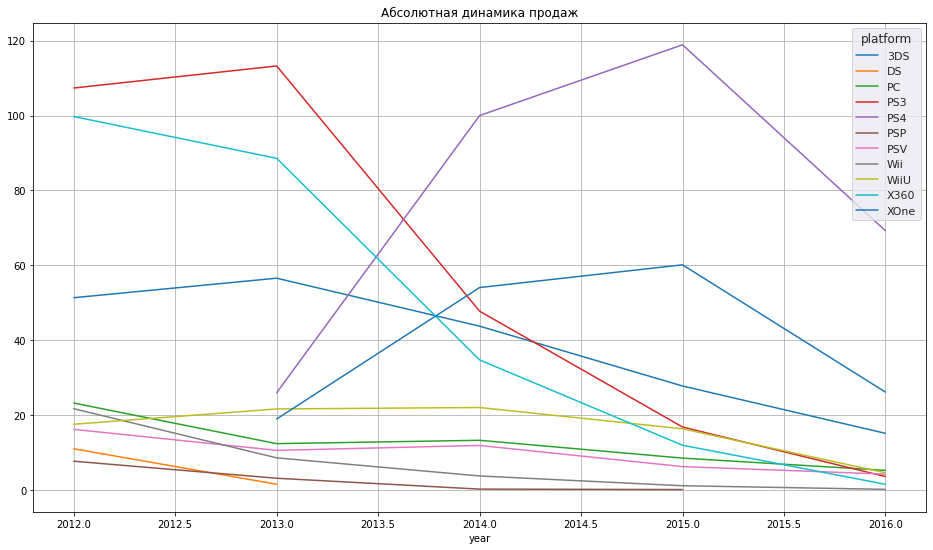

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.title('Абсолютная динамика продаж')
sns.set()
_=df.T.plot(ax=ax)

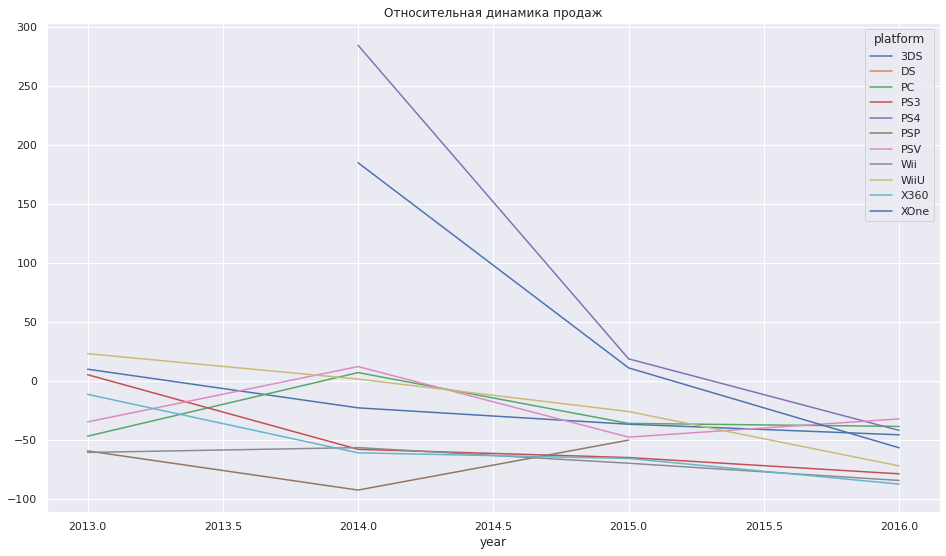

In [24]:
df = (df /df.shift(1, axis = 1) - 1) * 100

fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.title('Относительная динамика продаж')
sns.set()
_=df.T.plot(ax=ax)

Как видно из графиков и предыдущих этапов исследования 2017 не самый удачный преиод для выпуска игр, даже лучшие платформы уже пережили свой пик продаж и имею отрицательную динамику. Следовательно если предположительные тайтлы и должны появится то они появятся ближайший год или два, тк их начинали разрабатывать до этого момента и разработка длится примерно 2-3 года. Однако тут стоит учитывать обратную совместимость некоторых поколений консолей.

В нашем случае выбор падает на Xbox one и Playstation 4. Кто бы мог подумать.

### Распределения глобальных продаж игр в разбивке по платформам

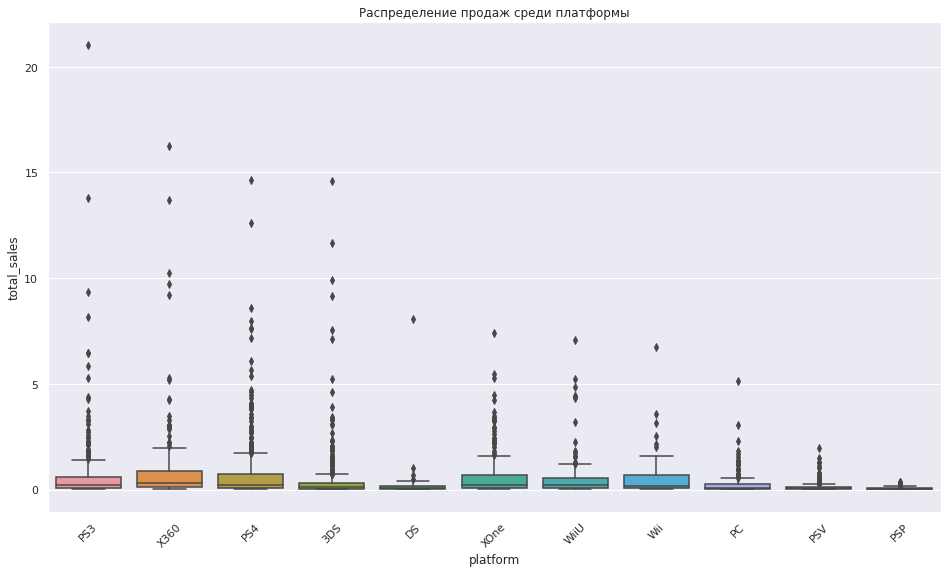

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.title('Распределение продаж среди платформы')
_=sns.boxplot(data=act_data, x='platform', y='total_sales', ax=ax)

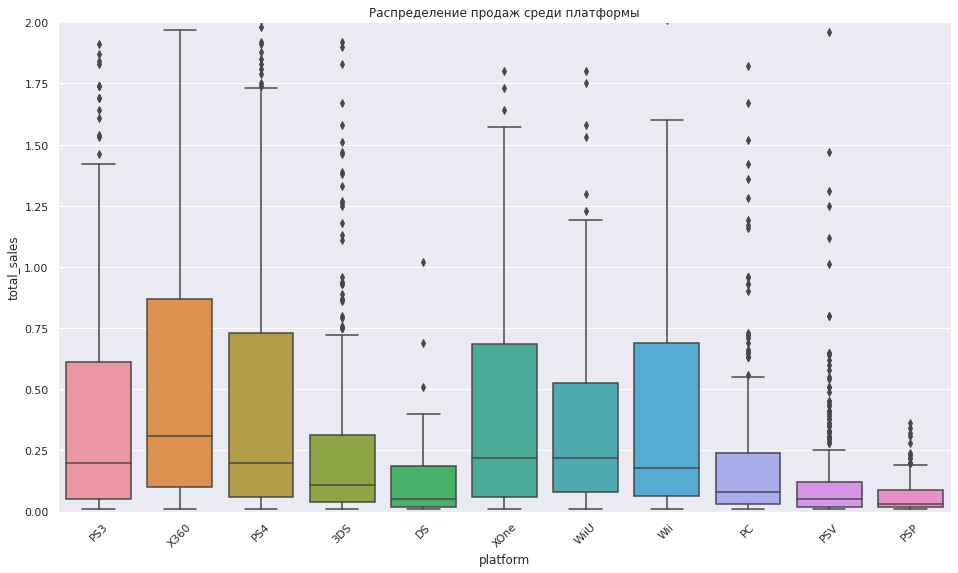

In [94]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=45)
plt.ylim(0,2)
plt.title('Распределение продаж среди платформы')
_=sns.boxplot(data=act_data, x='platform', y='total_sales', ax=ax)

Видно, что в продажах присутствуют тайтлы представляющие собой крупные выбросы по количеству проданных копий. Чаще всего это игры являющиеся частью ААА франшизы. Общая насыщенности рынка(в срезе жанров и сеттингов) и даты таких выбросов влияют на выход след. крупных тайтлов(попытка избежать конкуренции или наоборот проконкурировать более сильным тайтлом). Исходя из предположения что одинаковые по обьему пользователей и конкурирующие платформы, имеют примерно одинаковую модель выхода тайтлов, а следовательно распределение таких тайтлов(прим. PS и Xbox). Можно предположить, что вероятность появления крупно ААА тайтла на платформе Xbox one ближайшие один-два года выше. 

Однако в прошлые годы (консоли PS3 и Xbox 360) выходило немного больше игр, это так же имеет влияние на количество выбросов и в сочетании с вероятностью того, что Xbox one просто проиграл конкуренцию в области AAA франшиз, делает предположение в корне неверным.

В любом случае имеет смысл озадачится репутацией магазина среди владельцев Xbox one

### Корреляция отзывов и продаж у платформы PS4

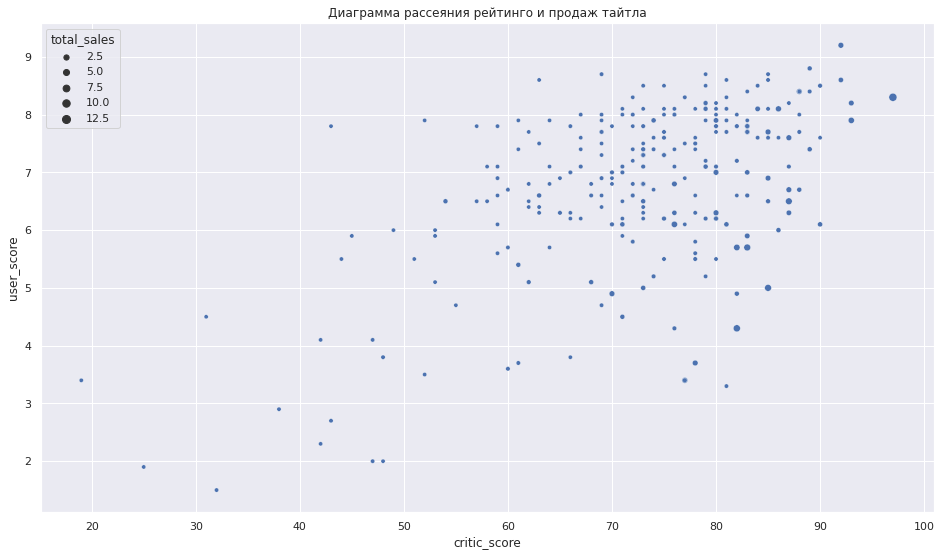

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.xticks(rotation=90)
plt.title('Диаграмма рассеяния рейтинго и продаж тайтла')
_=sns.scatterplot(data=act_data[act_data['platform'] == 'PS4'], x='critic_score', y='user_score',size='total_sales', ax=ax)

Оценки критиков появляются раньше пользовательского рейтинга. Следовательно обязательно влекут увеличение продаж, что подтверждается графиком. Так же отсутствует ситуация когда тайтл имеет низкие оценки критиков, но высокие продажи, что нельзя сказать про оценки пользователей. Если отслеживать динамику пользовательского рейтинга у каждого тайтла. С момента выхода до  окончания продаж. Можно было бы точно оценить влияние пользовательских оценок. В нашем же случае высокие пользовательские оценки позволяют скорее пост фактум оценить тайтл как успешный.

In [59]:
act_data[act_data['platform'] == 'PS4'][['user_score', 'critic_score', 'total_sales']].corr('pearson').iloc[[1,2], 0]

critic_score    0.557654
total_sales    -0.031957
Name: user_score, dtype: float64

Пользовательский рейтинг не имеет корреляции с продажами, как и на графике. Рейтинг критиков имеет сильную корреляцию и это логично.

In [84]:
tmp_act_data = act_data[act_data['user_score'].notna() & act_data['critic_score'].notna()]

In [85]:
tmp_act_data[tmp_act_data['platform'] == 'PS4'][['user_score', 'critic_score', 'total_sales']].corr('pearson')

,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.033625
critic_score,0.557654,1.000000,0.405895
total_sales,-0.033625,0.405895,1.000000


/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


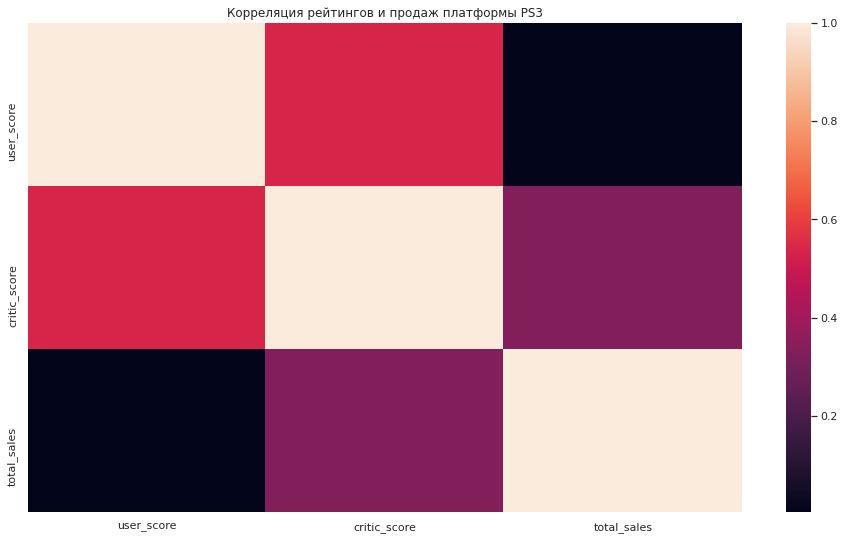

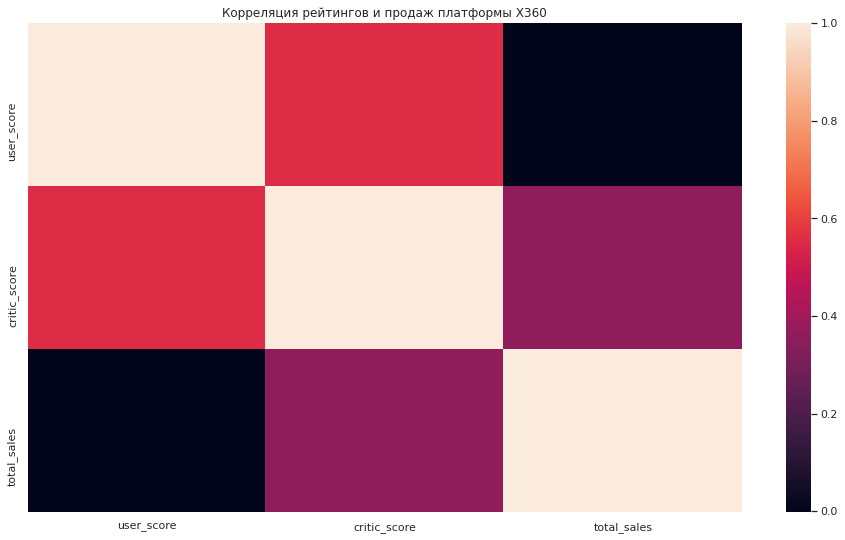

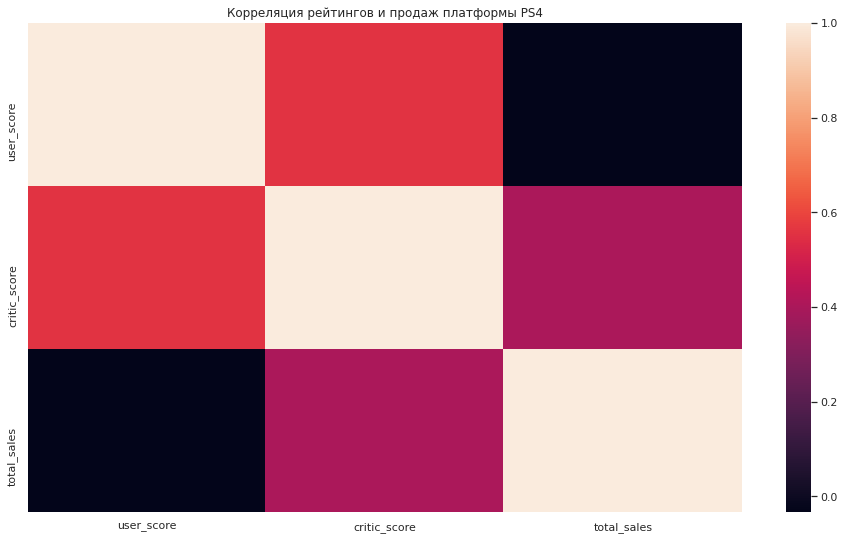

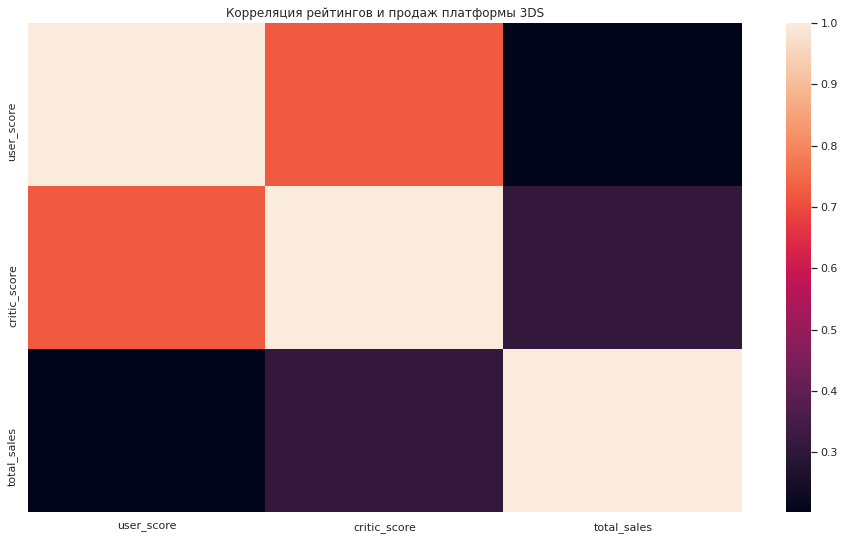

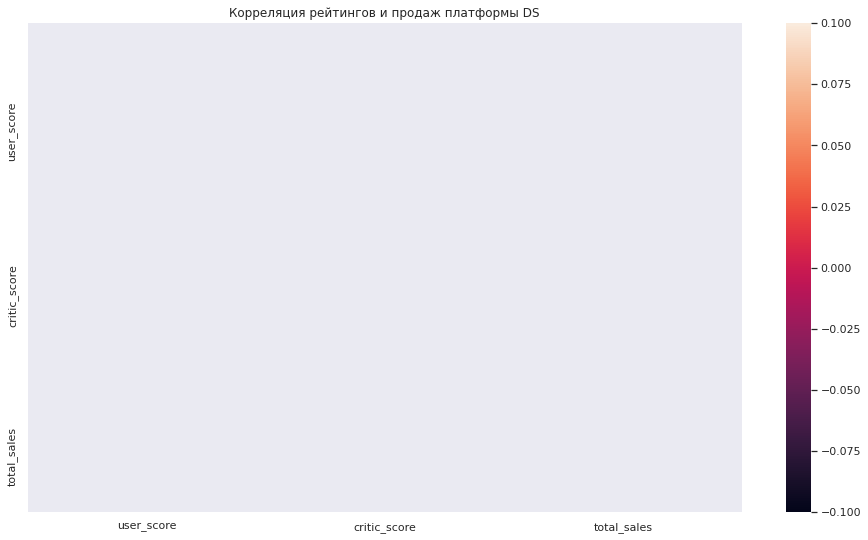

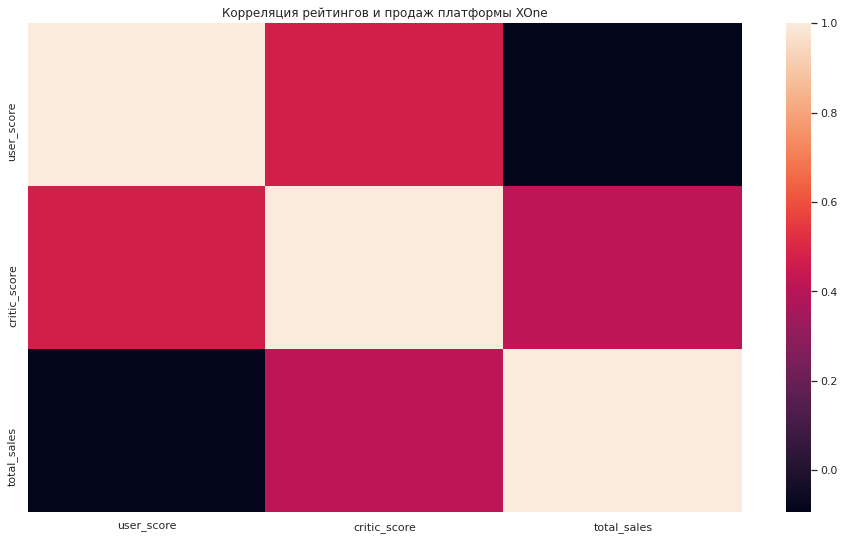

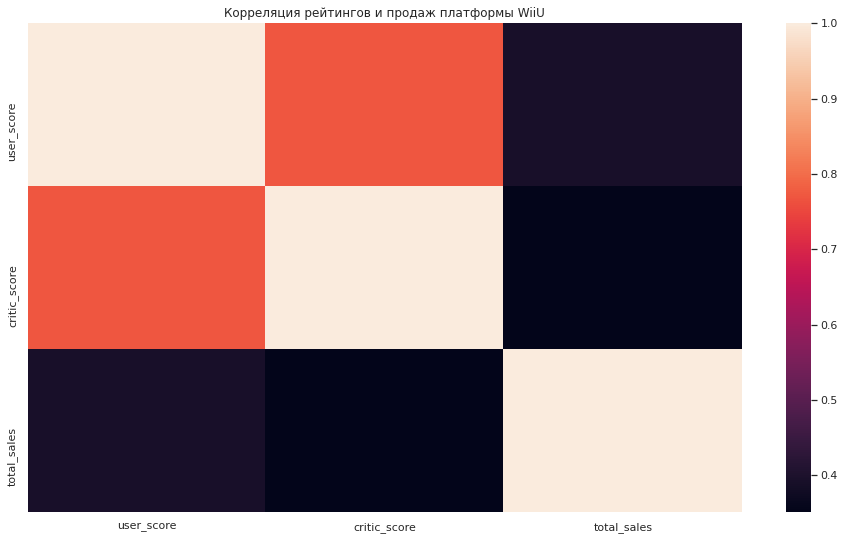

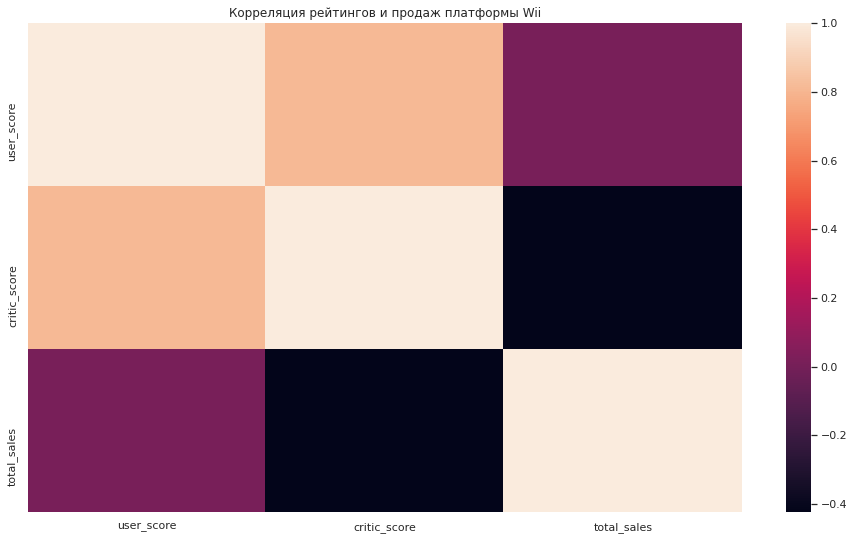

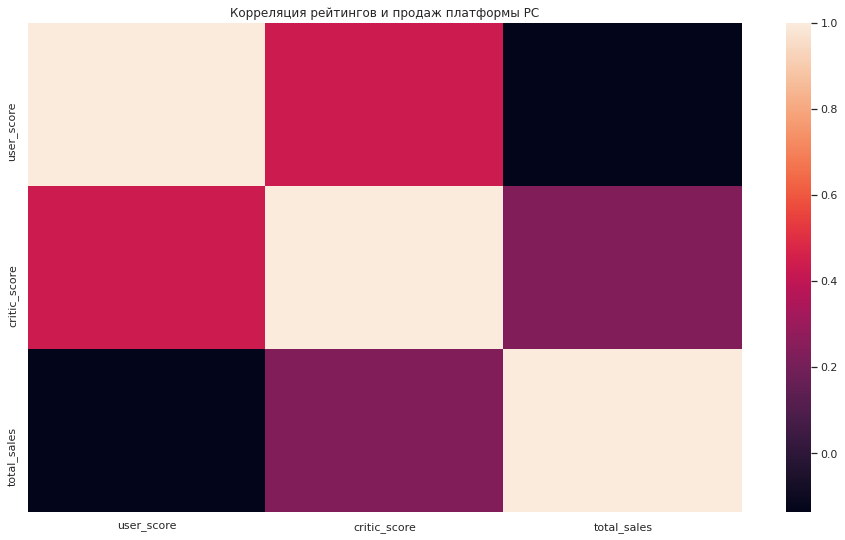

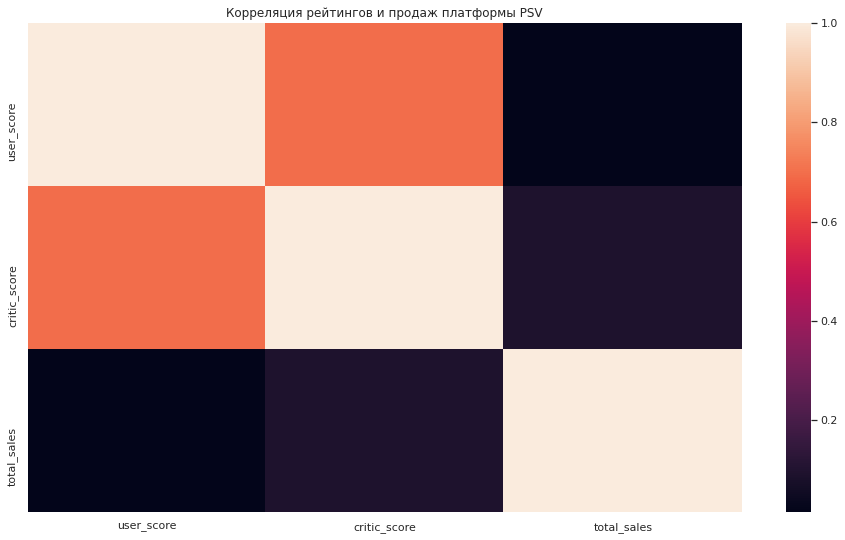

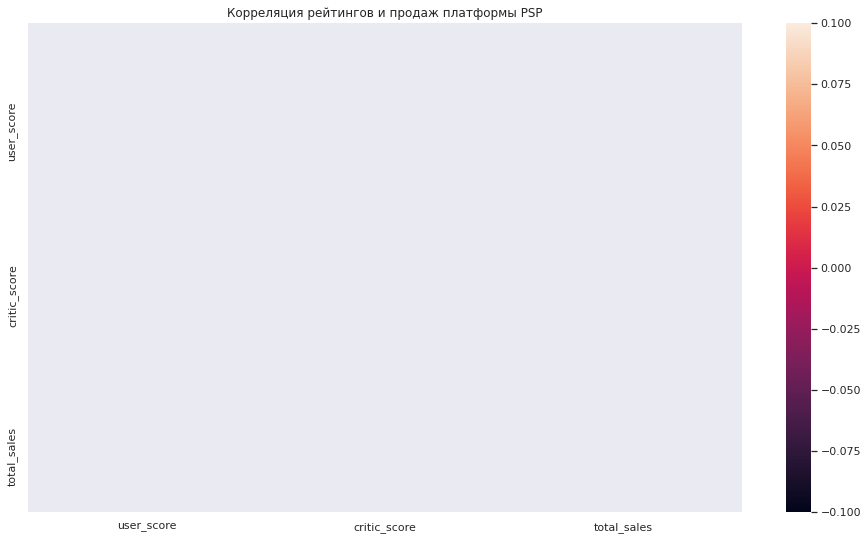

In [86]:
for p in act_data['platform'].unique():
    fig, ax = plt.subplots(figsize=(16, 9))
    #plt.xticks(rotation=90)
    plt.title(f'Корреляция рейтингов и продаж платформы {p}')
    _=sns.heatmap(data=tmp_act_data[tmp_act_data['platform'] == p][['user_score', 'critic_score', 'total_sales']].corr('pearson') ,ax=ax)

На всех платформах, есть сильная корреляци(ослабевает на Xbox и PS) между продажами и рейтингом критиков. Только на японской wii есть слабая корреляция между продажами и пользовательским рейтингом, у остальных платформ корреляция отсутсвует.

### Общее распределение игр по жанрам

In [75]:
act_data.groupby('genre')['total_sales'].agg(['sum', 'count', 'mean']).reset_index().sort_values(by='mean', ascending=False)

,genre,sum,count,mean
8,Shooter,304.73,235,1.296723
4,Platform,61.00,85,0.717647
10,Sports,181.07,268,0.675634
7,Role-Playing,192.80,370,0.521081
6,Racing,53.50,115,0.465217
3,Misc,85.04,192,0.442917
9,Simulation,35.12,80,0.439000
0,Action,441.12,1031,0.427856
2,Fighting,44.49,109,0.408165
11,Strategy,13.34,71,0.187887


В среднем, самый выгодный жанр Shooter лидирует с большим отрывом, остальные отличаются не так сильно.

In [73]:
act_data[act_data['platform'].isin(['PS4','XOne'])].groupby('genre')['total_sales'].agg(['sum', 'count', 'mean']).reset_index().sort_values(by='mean', ascending=False)

,genre,sum,count,mean
8,Shooter,148.89,79,1.884684
10,Sports,82.35,84,0.980357
7,Role-Playing,39.54,65,0.608308
0,Action,133.41,229,0.582576
6,Racing,21.93,39,0.562308
4,Platform,8.62,17,0.507059
2,Fighting,11.10,25,0.444000
3,Misc,15.62,39,0.400513
1,Adventure,9.02,42,0.214762
9,Simulation,1.92,10,0.192000


Взяв только классические консоли видим, Action попал в топ 5, вместо платформеровт т.к это жанр портативных платформ, шутер стал лидировать с еще большим отрывом уже в два раза.

In [76]:
df = act_data.groupby(['genre','year_of_release','platform'])['total_sales'].agg('mean').reset_index()
df.columns = ['genre','year_of_release','platform','sales']
genres = df['genre'].unique()

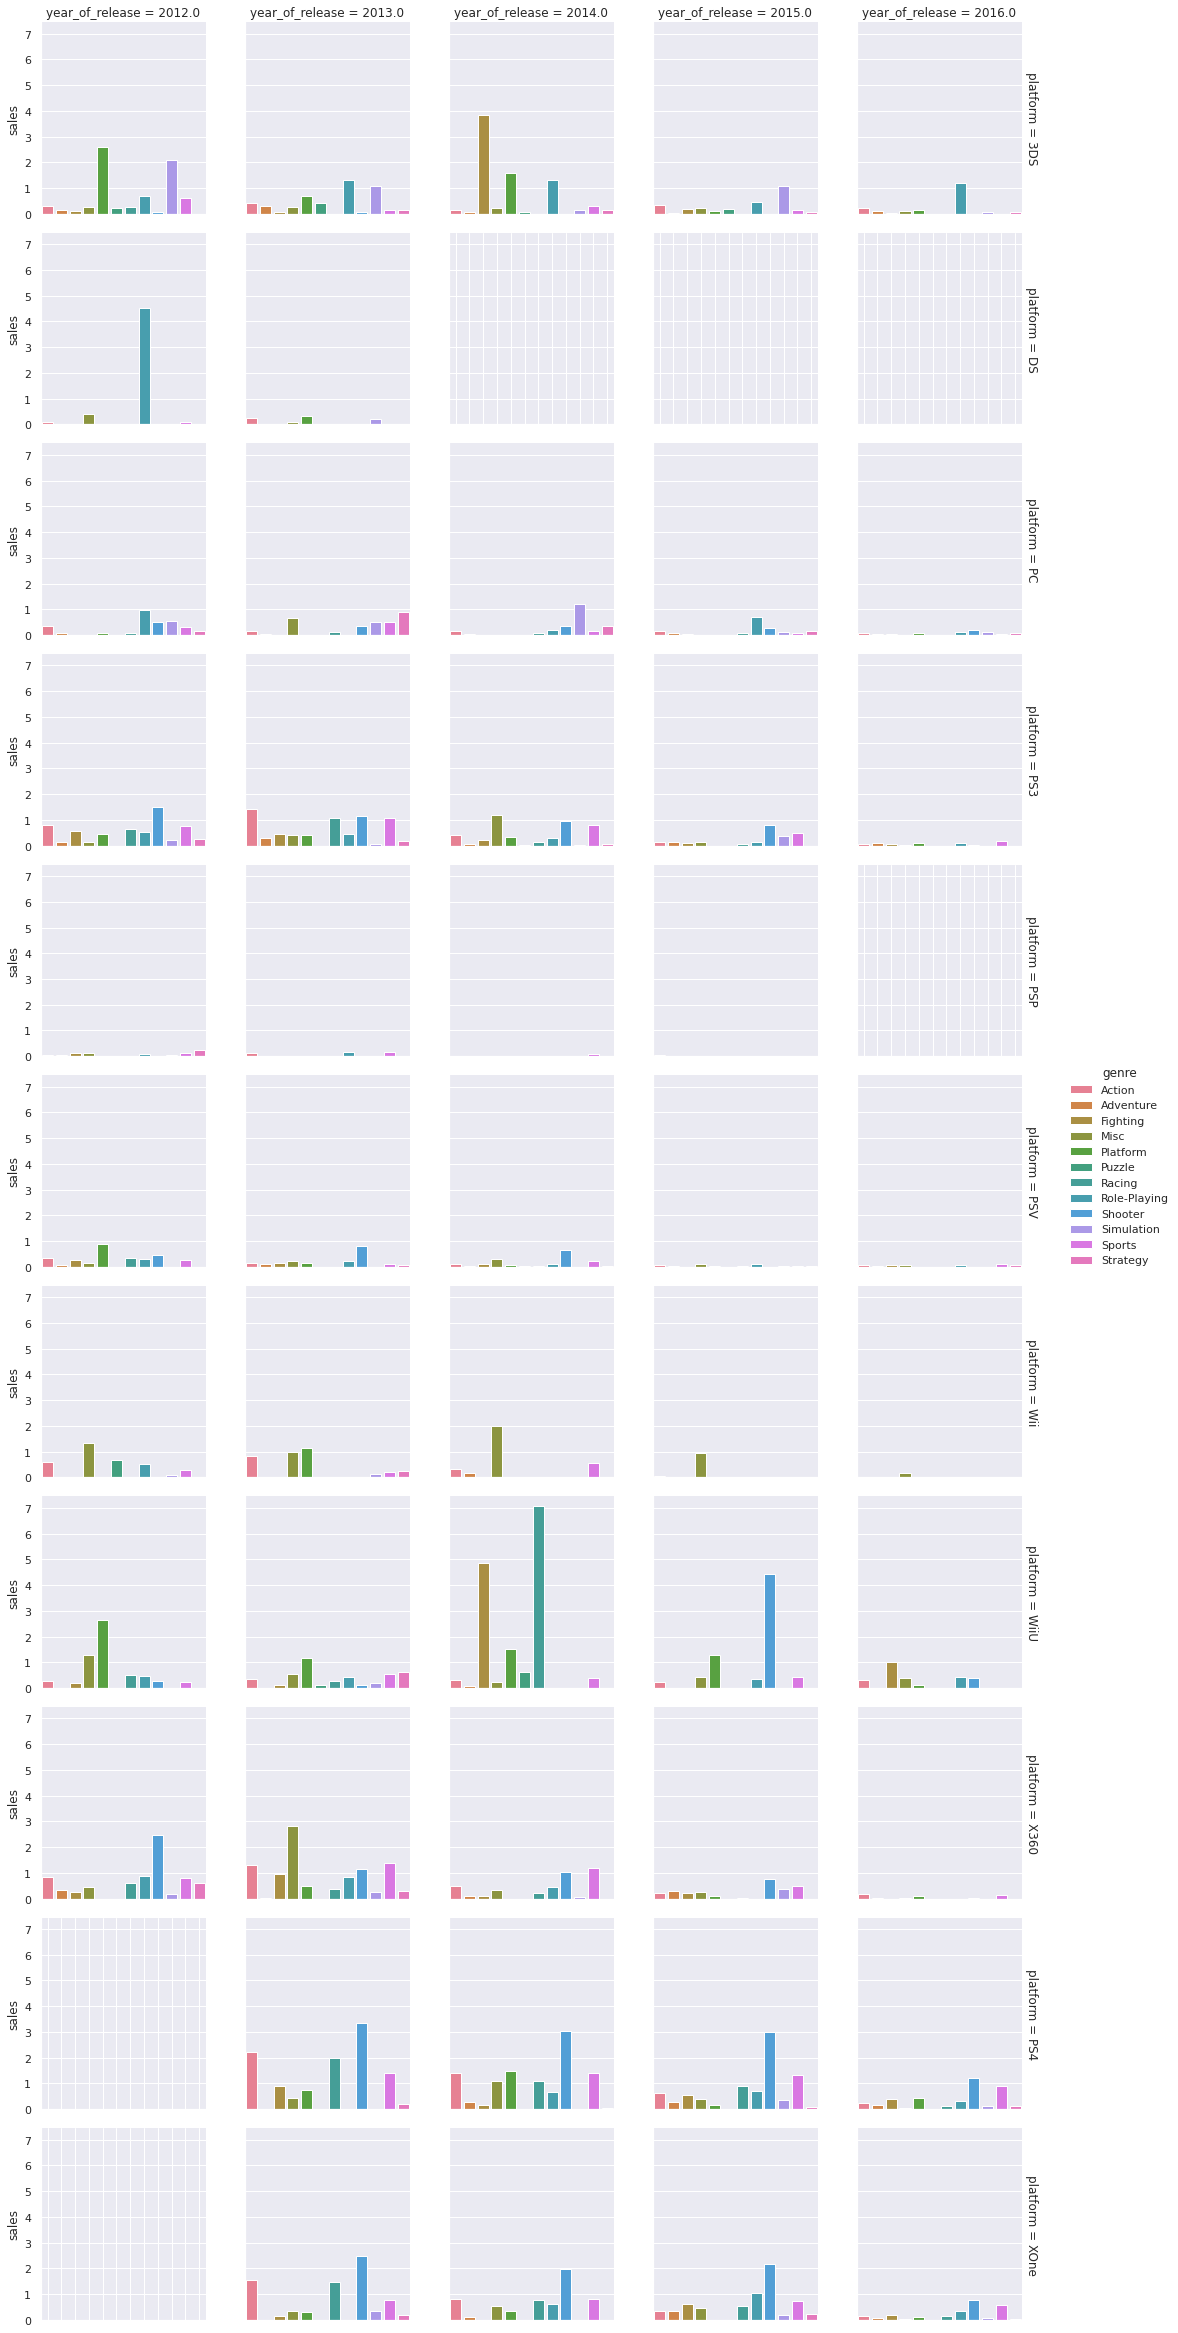

In [77]:
g = sns.FacetGrid(df, row= 'platform', col='year_of_release', hue='genre', legend_out=True, margin_titles = True)
_ = g.map(sns.barplot,'genre','sales',order=genres).set(xlabel='', xticklabels=[])
_ = g.add_legend()

Жанр Action больше популярен на классических консолях.

Жанр Sport популярнее на классических консолях.

Жанр Shooter почти отсутсвует на портативных консолях, зато там больше игр жанра Role-Playing.

Если смотреть на общие для большинства платформ тенденции то строгих глобальных тенденций для жанров не видно. Вероятнее всего тайтлы топ 4 жанров Action, RPG, Shooter, Sport распределяются во времени исходя из насыщенности рынка, что-бы не конкурировать за аудиторию.

Так же можно предположить что у платформы Xbox one, есть место на рынке для ролевых игр.

## Портрет пользователей по регионам  (NA, EU, JP)

### Платформы

In [34]:
df = act_data.groupby(['platform'])[['na_sales', 'eu_sales', 'jp_sales']].agg('sum').reset_index()
df.columns = ['platform','na_sales', 'eu_sales', 'jp_sales']

In [35]:
df.sort_values(by='na_sales', ascending=False)

,platform,na_sales,eu_sales,jp_sales
9,X360,140.05,74.52,1.57
4,PS4,108.74,141.09,15.96
3,PS3,103.38,106.86,35.29
10,XOne,93.12,51.59,0.34
0,3DS,55.31,42.64,87.79
8,WiiU,38.10,25.13,13.01
2,PC,19.12,37.76,0.00
7,Wii,17.45,11.92,3.39
6,PSV,10.98,11.36,21.04
1,DS,4.59,3.53,3.72


In [36]:
df.sort_values(by='jp_sales', ascending=False)

,platform,na_sales,eu_sales,jp_sales
0,3DS,55.31,42.64,87.79
3,PS3,103.38,106.86,35.29
6,PSV,10.98,11.36,21.04
4,PS4,108.74,141.09,15.96
8,WiiU,38.10,25.13,13.01
5,PSP,0.13,0.42,10.47
1,DS,4.59,3.53,3.72
7,Wii,17.45,11.92,3.39
9,X360,140.05,74.52,1.57
10,XOne,93.12,51.59,0.34


Северная америка и европа приципиально отличаются только победой Xbox в NA и победой PlayStation в EU.

В Японии картина совершенно другая, японцы значительно медленнее переходят на PS4 с PS3, чем американцы и европейцы. В топе отсутствует продукция microsot. Лидирует портативная консоль местного производства nintendo 3DS, которая в других регионах занимает 4-5 место. Ну и в целом топ 5 это все местные игроки(слава императору), игровой рынок в японии жесткий.

### Жанры

In [37]:
df = act_data.groupby(['genre'])[['na_sales', 'eu_sales', 'jp_sales']].agg('sum').reset_index()
df.columns = ['genre','na_sales', 'eu_sales', 'jp_sales']

In [38]:
df.sort_values(by='na_sales', ascending=False)

,genre,na_sales,eu_sales,jp_sales
0,Action,177.84,159.34,52.80
8,Shooter,144.77,113.47,9.23
10,Sports,81.53,69.09,8.01
7,Role-Playing,64.00,48.53,65.44
3,Misc,38.19,26.32,12.86
4,Platform,25.38,21.41,8.63
2,Fighting,19.79,10.79,9.44
6,Racing,17.22,27.29,2.50
1,Adventure,8.92,9.46,8.24
9,Simulation,7.97,14.55,10.41


NA и EU отличаются только 5 местом, вмест Misc в европе будут гонки.

In [39]:
df.sort_values(by='jp_sales', ascending=False)

,genre,na_sales,eu_sales,jp_sales
7,Role-Playing,64.00,48.53,65.44
0,Action,177.84,159.34,52.80
3,Misc,38.19,26.32,12.86
9,Simulation,7.97,14.55,10.41
2,Fighting,19.79,10.79,9.44
8,Shooter,144.77,113.47,9.23
4,Platform,25.38,21.41,8.63
1,Adventure,8.92,9.46,8.24
10,Sports,81.53,69.09,8.01
11,Strategy,4.23,5.17,2.88


Из примечательного Action в топ 5. Вместо шутеров и спортивных игр в JP симуляторы и  файтинги.

### Возрастной рейтинг

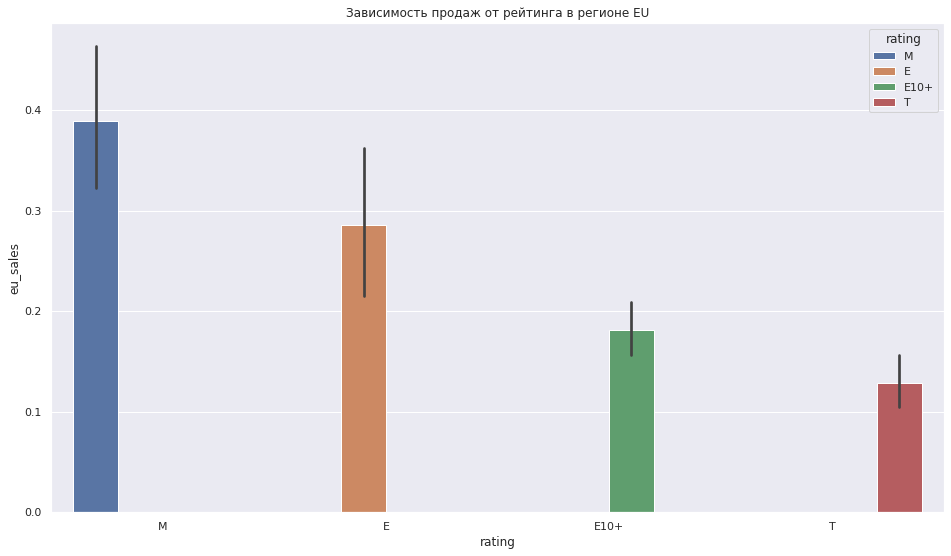

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.xticks(rotation=90)
plt.title('Зависимость продаж от рейтинга в регионе EU')
_=sns.barplot(y = 'eu_sales', x = 'rating', data=act_data, hue='rating', ax=ax)

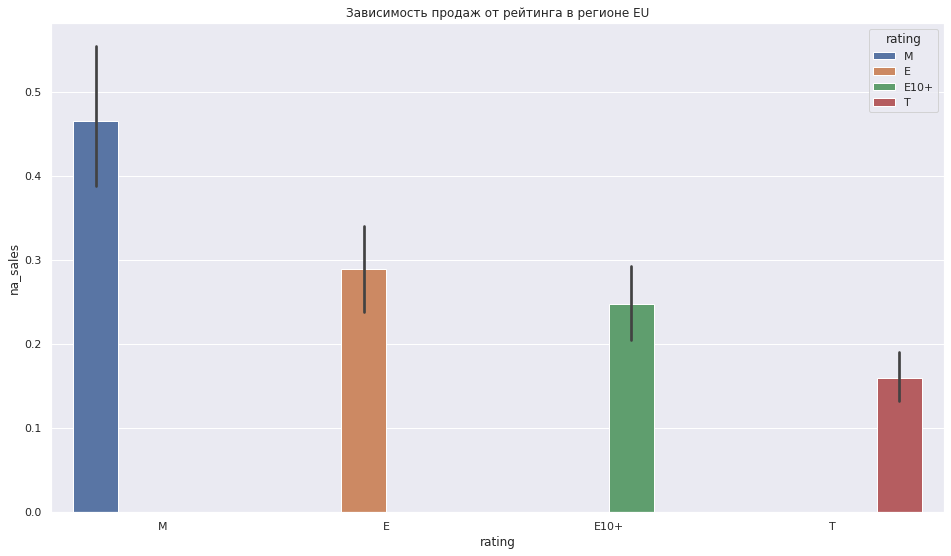

In [41]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.xticks(rotation=90)
plt.title('Зависимость продаж от рейтинга в регионе EU')
_=sns.barplot(y = 'na_sales', x = 'rating', data=act_data, hue='rating', ax=ax)

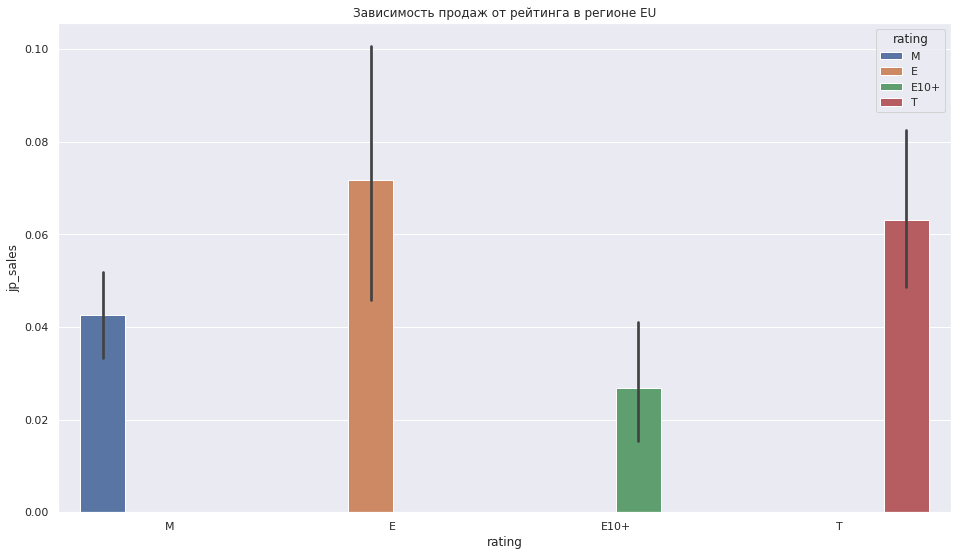

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
#plt.xticks(rotation=90)
plt.title('Зависимость продаж от рейтинга в регионе EU')
_=sns.barplot(y = 'jp_sales', x = 'rating', data=act_data, hue='rating', ax=ax)

Европа и Северная америка практически не отличаются в свое отношении к возрастному рейтингу. В Японии аудитория геймеров явно отличается по возрасту, здесь более популярны тайтлы для подростков и тайтлы для всех, в отличии от EU и NA где большие продажи имеют тайтлы для 17+. Нельзя на точно сказать на данном этапе, связанно ли это с культурой или с альтернативном рейтингом игровых жанров и консолей. Но такие существенные различия необходимо учитывать при работе с японским рынком игр.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

С логической точки зрения и исходя из моего личного опыта, такого просто не может быть. Если говорить о генеральны совокупностях, то ГC пользовательских рейтингов,рынка PC, знаительно больше и имеет значительно большую дисперсию исходя из логики работы самих рынков игр PC и Xbox(один свободный, другой регулируется). Более того требуется сравнить рейтинги не всех платформ Xbox а только одной конкретной Xbox one, что уже странно. Т.к данные изначально кукольные, буду проводить статистический тест не предвзято. Считать рейтинги выборками из разных ГС т.к. разные рынки.

In [43]:
act_data[act_data['platform'] == 'PC']['user_score'].mean()

6.428640776699029

In [44]:
act_data[act_data['platform'] == 'XOne']['user_score'].mean()

6.521428571428572

H0 - средние рейтинги равны, H1 - средние рейтинги не равны.

In [45]:
alpha = 0.1
a1 = act_data[(act_data['platform'] == 'PC') & (act_data['user_score'].notna())]['user_score'].values
a2 = act_data[(act_data['platform'] == 'XOne') & (act_data['user_score'].notna())]['user_score'].values
test_res = st.ttest_ind(a1, a2,equal_var = False)

print('p-value',test_res.pvalue)

if test_res.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Вероятность случайно получить такое или большее различие 54%. Оставляет нулевую гипотезу, какой бы странной она и эта выборка(все данные в целом) не была.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Гипотеза вполне логичная, оба жанра хорошо продаются, но как мы видели ранее, пользовательские оценки не влияют на продажи значимым образом, скорее они уже вопрос репутации разработчика. Рейтинги должны скорее отличатся, чем оказатся равными. Интуитивно и из опыта это мне понятно. Т.к средний рейтинг скорее зависит от неудачных тайтлов и их кол-ва , игры этих жанров выпускаются в разных кол-вах, Action игр на много больше. Получается средний рейтинг экшенов должен оказатся ниже, среднего спортивных. Так же жанр Action более широкий в плане сеттингов и исполнения и может посто не заходить, при условии выского качества продуктов. Sports имеет более жесткие рамки, и чаще будет соответствовать ожиданиям, при условии выского качества продуктов.

In [46]:
act_data[act_data['genre'] == 'Action']['user_score'].mean()

6.825047801147227

In [47]:
act_data[act_data['genre'] == 'Sports']['user_score'].mean()

5.455897435897437

В нашей выборке все на оборот. . .

H0 - Средние рейтинги равны, H1 - средние рейтинги не равны.

In [48]:
alpha = 0.1
a1 = act_data[(act_data['genre'] == 'Action') & (act_data['user_score'].notna())]['user_score'].values
a2 = act_data[(act_data['genre'] == 'Sports') & (act_data['user_score'].notna())]['user_score'].values
test_res = st.ttest_ind(a1, a2,equal_var = False)

print('p-value',test_res.pvalue)

if test_res.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value 4.24307776572644e-20
Отвергаем нулевую гипотезу


Вероятность случайно получить такое различие крайне мала. Есть основания полагать что в ГС средние рейтинги так же будут не равны.

## Общий вывод

На данный период времени 2016г все платформы имеют отрицательную динамику продаж и их жизненый цикл вероятно подходит к концу. В связи с этим ожидается снижение кол-ва ААА тайтлов и общего числа игр на рынке, что создает возможности для менее крупных игроков.

Для NA и EU целевой является возрастная аудитория M, для JP E и T.


Согласно общим показателям продаж на рынке классических консолей, на рынке Xbox One есть пространство для выхода AAA тайтла в жанре Role-Playing или Shooter, рынок PS выглядит исчерпаным относительно продаж прошлых годов. Вывод верен только при наличии здоровой конкуренции между PS4 и Xbox One в данный временной сегмент, без значимого преимущества PS, в консолях я не эксперт.

На всех платформах, есть сильная корреляци(ослабевает на Xbox и PS) между продажами и рейтингом критиков. Только на японской wii есть слабая корреляция между продажами и пользовательским рейтингом, у остальных платформ корреляция отсутсвует.
Соглассно исследованию, ставки стоит делать на классические платфрмы в регионах EU и NA и портативные в регионе JP.

Гипотезы:

* По имеющимся выборкам не удалось отвергнуть гипотезу о равенстве средних рейтингов пользователей у тайтлов Xbox и PC и удалось отвергнуть гипотезу о равенстве средних рейтингов тайтлов жанра Action и Sports.

Рекомендации:
* Рынок игр на классических консолях переживает спад, до выхода след. поколения спрос на нем будет убывать, консоли и PC в этом плане тихая гавань там не густо но и не пусто.
* На рынке Xbox продажи в основных жанрах, были ниже обычного, вероятность выхода серьезного ААА тайтла в жанре Shooter или RPG, значительно выше обычного.
* Наиболее продающиеся жанры в последние годы это Shooter, Sports, RPG, Action
* Для точного анализа следует анализировать портативные консоли отдельно т.к в них обнаружилось большое разнообразие тенденций в срезе жанров, возрастов и регионов.